<a href="https://colab.research.google.com/github/fjadidi2001/DecompDenoise/blob/main/DD_Feb12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### **1. Define the Problem Statement**
- Noise in images can arise from various sources (sensor noise, compression artifacts, environmental conditions, etc.).
- Your goal is to **reduce noise while preserving edges and details**.
- You will use a **decomposition-based technique** to separate noise from useful image content.

---

### **2. Select the Decomposition Technique**
Several decomposition methods can be used:
- **Wavelet Transform** (DWT) – Multiscale decomposition to remove high-frequency noise.  
- **Variational Mode Decomposition (VMD)** – Adaptive signal decomposition.  
- **Empirical Mode Decomposition (EMD)** – Decomposes signals into Intrinsic Mode Functions (IMFs).  
- **Singular Value Decomposition (SVD)** – Identifies noise components by analyzing singular values.  


---

### **3. Workflow Overview**
#### **Step 1: Load and Preprocess the Image**
- Read the noisy image.  
- Convert it to grayscale if necessary.  
- Normalize pixel values.  

#### **Step 2: Apply the Decomposition Technique**
- Decompose the image using the selected method (DWT, VMD, EMD, or SVD).  
- Identify noisy components.  

#### **Step 3: Remove Noise**
- Apply thresholding or filtering techniques.  
- Reconstruct the image from the processed components.  

#### **Step 4: Evaluate the Results**
- Compare the denoised image with the original.  
- Use quality metrics:  
  - **PSNR (Peak Signal-to-Noise Ratio)**  
  - **SSIM (Structural Similarity Index Measure)**  
  - **MSE (Mean Squared Error)**  

#### **Step 5: Optimize Performance**
- Experiment with different decomposition parameters.  
- Compare results with traditional methods (Gaussian filter, median filter, etc.).  

---



s---

### **Flowchart for Noise Reduction Using Decomposition Technique**  

✅ **Preprocessing** (grayscale conversion, normalization, etc.)  
✅ **Decomposition technique** (DWT, VMD, EMD, or SVD)  
✅ **Denoising & Reconstruction**  
✅ **Visualization at Each Step**  

---

### **Flowchart**
```plaintext
         Start
           │
           ▼
  Load Noisy Image
           │
           ▼
  Preprocess Image
    (Grayscale, Resize, Normalize)
           │
           ▼
 Apply Decomposition
  (DWT, VMD, EMD, SVD)
           │
           ▼
  Identify Noise Components
           │
           ▼
    Filter or Threshold Noise
           │
           ▼
 Reconstruct Denoised Image
           │
           ▼
  Evaluate Results (PSNR, SSIM)
           │
           ▼
   Visualize Steps & Compare
           │
           ▼
         End
```

---




# Step 1: Load and Preprocess the Image

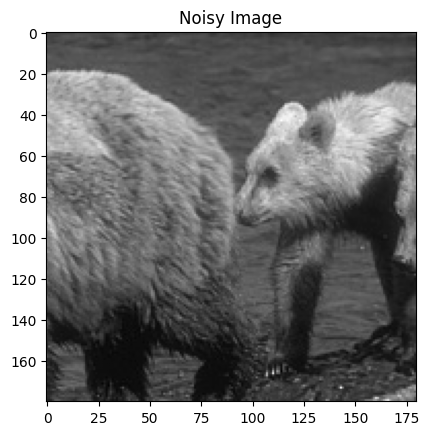

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image
image = cv2.imread('test_001.png', cv2.IMREAD_GRAYSCALE)

# Normalize image
image = image.astype(np.float32) / 255.0

# Visualize
plt.imshow(image, cmap='gray')
plt.title('Noisy Image')
plt.show()

# Step 2: Apply Decomposition Technique

In [22]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 63.6 MB/s eta 0:00:00


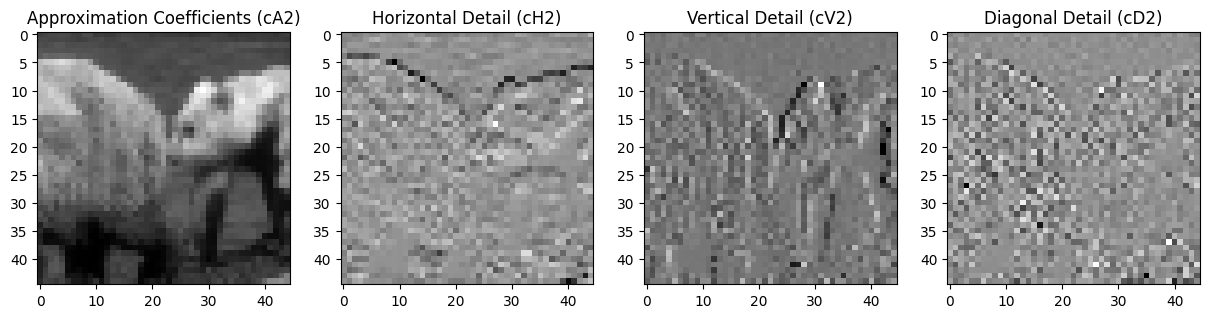

In [25]:
import pywt

# Apply Discrete Wavelet Transform (DWT)
coeffs = pywt.wavedec2(image, 'db1', level=2)

# coeffs structure for level 2: [cA2, (cH2, cV2, cD2), (cH1, cV1, cD1)]
# Accessing the coefficients:
cA2 = coeffs[0]  # Approximation coefficients at level 2
cH2, cV2, cD2 = coeffs[1]  # Detail coefficients (H, V, D) at level 2
cH1, cV1, cD1 = coeffs[2]  # Detail coefficients (H, V, D) at level 1


# Visualize decomposition for level 2
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
axs[0].imshow(cA2, cmap='gray')  # Approximation coefficients at level 2
axs[0].set_title('Approximation Coefficients (cA2)')
axs[1].imshow(cH2, cmap='gray')  # Horizontal detail at level 2
axs[1].set_title('Horizontal Detail (cH2)')
axs[2].imshow(cV2, cmap='gray')  # Vertical detail at level 2
axs[2].set_title('Vertical Detail (cV2)')
axs[3].imshow(cD2, cmap='gray')  # Diagonal detail at level 2
axs[3].set_title('Diagonal Detail (cD2)')
plt.show()

In [29]:
# Set threshold for noise removal
threshold = 0.1

# Assuming cH1, cV1, cD1 correspond to LH, HL, HH at level 1
cH1 = pywt.threshold(cH1, threshold, mode='soft')
cV1 = pywt.threshold(cV1, threshold, mode='soft')
cD1 = pywt.threshold(cD1, threshold, mode='soft')

# Assuming cH2, cV2, cD2 correspond to LH, HL, HH at level 2
cH2 = pywt.threshold(cH2, threshold, mode='soft')
cV2 = pywt.threshold(cV2, threshold, mode='soft')
cD2 = pywt.threshold(cD2, threshold, mode='soft')

In [30]:
# Reconstruct image
coeffs_filtered = [LL, (LH, HL, HH)]
image_denoised = pywt.waverec2(coeffs_filtered, 'db1')

# Visualize results
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Noisy Image')
axs[1].imshow(image_denoised, cmap='gray')
axs[1].set_title('Denoised Image')
plt.show()

NameError: name 'LL' is not defined